In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
num_epochs = 80
learning_rate = 0.001

In [ ]:
# Image preprocessing 
transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor()])

In [ ]:
# CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                             train=True, 
                                             transform=transform,
                                             download=True)

test_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                            train=False, 
                                            transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=100, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=100, 
                                          shuffle=False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../../data/cifar-10-python.tar.gz to ../../data/


In [ ]:
# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

model = ResNet(ResidualBlock, [2, 2, 2]).to(device)

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Train the model
total_step = len(train_loader)
curr_lr = learning_rate
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/80], Step [100/500] Loss: 1.5855
Epoch [1/80], Step [200/500] Loss: 1.3642
Epoch [1/80], Step [300/500] Loss: 1.3383
Epoch [1/80], Step [400/500] Loss: 1.0723
Epoch [1/80], Step [500/500] Loss: 1.1901
Epoch [2/80], Step [100/500] Loss: 0.8092
Epoch [2/80], Step [200/500] Loss: 1.2410
Epoch [2/80], Step [300/500] Loss: 0.8392
Epoch [2/80], Step [400/500] Loss: 0.9387
Epoch [2/80], Step [500/500] Loss: 0.9899
Epoch [3/80], Step [100/500] Loss: 0.8300
Epoch [3/80], Step [200/500] Loss: 0.8914
Epoch [3/80], Step [300/500] Loss: 0.8056
Epoch [3/80], Step [400/500] Loss: 0.6526
Epoch [3/80], Step [500/500] Loss: 1.1167
Epoch [4/80], Step [100/500] Loss: 0.6544
Epoch [4/80], Step [200/500] Loss: 0.8831
Epoch [4/80], Step [300/500] Loss: 0.9108
Epoch [4/80], Step [400/500] Loss: 0.8585
Epoch [4/80], Step [500/500] Loss: 0.7471
Epoch [5/80], Step [100/500] Loss: 0.7539
Epoch [5/80], Step [200/500] Loss: 0.7167
Epoch [5/80], Step [300/500] Loss: 0.5012
Epoch [5/80], Step [400/500] Loss:

In [ ]:
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

Accuracy of the model on the test images: 87.96 %


In [ ]:
# Save the model checkpoint
torch.save(model.state_dict(), 'resnet.ckpt')

In [ ]:
# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = torch.flatten(out, 1)

        return out

model = ResNet(ResidualBlock, [2, 2, 2]).to(device)
model.load_state_dict(torch.load("/content/resnet.ckpt"))
features = None
labels_list = []

for index,(images, labels) in enumerate(test_loader):
  if index > 50:
    break
  images = images.to(device)
  labels_list.extend(labels.numpy())
  
  with torch.no_grad():
    out = model.forward(images)

  current_features = out.cpu().numpy()
  print(current_features.shape)

  if features is not None:
    features = np.concatenate((features, current_features))
  else:
    features = current_features

(100, 64)
(100, 64)
(100, 64)
(100, 64)
(100, 64)
(100, 64)
(100, 64)
(100, 64)
(100, 64)
(100, 64)
(100, 64)
(100, 64)
(100, 64)
(100, 64)
(100, 64)
(100, 64)
(100, 64)
(100, 64)
(100, 64)
(100, 64)
(100, 64)
(100, 64)
(100, 64)
(100, 64)
(100, 64)
(100, 64)
(100, 64)
(100, 64)
(100, 64)
(100, 64)
(100, 64)
(100, 64)
(100, 64)
(100, 64)
(100, 64)
(100, 64)
(100, 64)
(100, 64)
(100, 64)
(100, 64)
(100, 64)
(100, 64)
(100, 64)
(100, 64)
(100, 64)
(100, 64)
(100, 64)
(100, 64)
(100, 64)
(100, 64)
(100, 64)


In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3).fit_transform(features)

In [ ]:
def scale_to_01_range(x):
    value_range = (np.max(x) - np.min(x))
    starts_from_zero = x - np.min(x)
    
    return starts_from_zero / value_range

In [ ]:
tx = scale_to_01_range(tsne[:, 0])
ty = scale_to_01_range(tsne[:, 1])
tz = scale_to_01_range(tsne[:, 2])

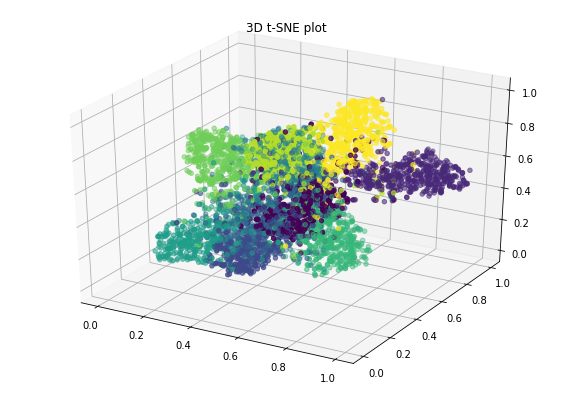

In [ ]:
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(tx, ty, tz, c = labels_list)
plt.title("3D t-SNE plot")
 
# show plot
plt.show()

In [ ]:
tsne = TSNE(n_components=2).fit_transform(features)

In [ ]:
tx = scale_to_01_range(tsne[:, 0])
ty = scale_to_01_range(tsne[:, 1])

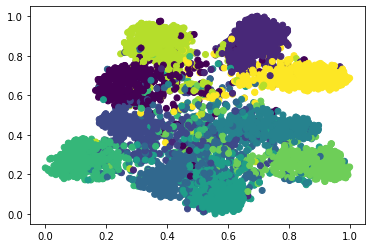

In [ ]:
plt.scatter(tx, ty, c=labels_list)
plt.show()